In this notebook we perform EDA on the dataset we have been provided for this project. We need to do this before we create a pipeline for the ML workflow.

Note that the main point of this project is to understand how the process of EDA works in the context of pipelines during the data exploration phase. Here we just condider the bare minimum EDA to understand the process. In reality we would want to spend much more time on this part.

In [1]:
import wandb
import pandas as pd
import pandas_profiling

# Read data from Weights & Biases
The first step is to read the raw data that we stored in our W&B project into a Pandas DataFrame. To do this, we first need to initialize a new run in W&B using the `init()` method. To this we need to pass the project name where we stored the data for this project (nyc_airbnb). We can also name the experiment using the `group` parameter. Doing this, W&B will start tracking system metrics and console logs.

**Important:** Before running this, you need to have logged into your W&B account by running `wandb login <API_KEY>`. You can generate the API key from your account in W&B.

In [2]:
run = wandb.init(project="nyc_airbnb", group="eda", save_code=True)

wandb: Currently logged in as: robsmith155 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


**Note:** The `save_code=True` parameter means that the code (in this case a Notebook) will be uploaded and tracked by W&B. 

Now we read the file that was downloaded into a DataFrame. Note here that we can use the `file()` method on the W&B artifact to get the path for the file.

In [35]:
local_path = wandb.use_artifact("sample.csv:latest").file()

In [36]:
local_path

'./artifacts/sample.csv:v0/sample1.csv'

In [37]:
df = pd.read_csv(local_path)

In [38]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9138664,Private Lg Room 15 min to Manhattan,47594947,Iris,Queens,Sunnyside,40.74271,-73.92493,Private room,74,2,6,2019-05-26,0.13,1,5
1,31444015,TIME SQUARE CHARMING ONE BED IN HELL'S KITCHEN...,8523790,Johlex,Manhattan,Hell's Kitchen,40.76682,-73.98878,Entire home/apt,170,3,0,NaN,NaN,1,188
2,8741020,Voted #1 Location Quintessential 1BR W Village...,45854238,John,Manhattan,West Village,40.73631,-74.00611,Entire home/apt,245,3,51,2018-09-19,1.12,1,0
3,34602077,Spacious 1 bedroom apartment 15min from Manhattan,261055465,Regan,Queens,Astoria,40.76424,-73.92351,Entire home/apt,125,3,1,2019-05-24,0.65,1,13
4,23203149,Big beautiful bedroom in huge Bushwick apartment,143460,Megan,Brooklyn,Bushwick,40.69839,-73.92044,Private room,65,2,8,2019-06-23,0.52,2,8


In [39]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20000 non-null  int64  
 1   name                            19993 non-null  object 
 2   host_id                         20000 non-null  int64  
 3   host_name                       19992 non-null  object 
 4   neighbourhood_group             20000 non-null  object 
 5   neighbourhood                   20000 non-null  object 
 6   latitude                        20000 non-null  float64
 7   longitude                       20000 non-null  float64
 8   room_type                       20000 non-null  object 
 9   price                           20000 non-null  int64  
 10  minimum_nights                  20000 non-null  int64  
 11  number_of_reviews               20000 non-null  int64  
 12  last_review                     

# Analyse the data using pandas-profiling

Here we will use the `pandas-profiling` package to generate a report that allows us to easily identify issues in the dataset.

In [41]:
profile = pandas_profiling.ProfileReport(df)
profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Data issues and observations
Below are some of the issues that have been identified from the report above:
- The `last_review` and `reviews_per_month` features are both missing in around 1/5 of the samples
- The `last_review` feature is a date but is currently a string
- The `number_of_reviews` and `availability_365` features both contain a high percentage of zeros (21% and 36% respectively)
- The `minimum_nights` variable is highly skewed, with a mean value of 7 days but maximum value of 1250. Since it is likely that someone would get a reduced rate for a long term retal, it might be worth considering removing these outliers from the dataset.
- The `price` variable (which is what we want to predict) is also highly skewed, with a median price of 105 but maximum of 10000. There are also a few entries which are zero, which doesn't make sense. We may want to remove these outliers.
- The `id` feature is not useful as it is a unique value for each sample
- The `name` and `host_name` features are also probably not useful since most entries have a unique string (i.e. high cardinality). We have the `host_id` feature which is a unique id for each host.
- The dataset contains properties from five districts in New York, but the majority (~80%) are in Manhattan or Brooklyn. Would need to check whether the model performs well on the other districts (Queens, Bronx, Staten Island), because the performance will be dominated by the main two
- Under the `room_type` feature, we see that almost all of the properties for rent are either for the entire home or for a private room. Their are also a small amount of shared room examples (444/20000).
- The `calculated_host_listings_count` is also highly skewed, with a median value of one, but some outliers of up to 327





# Fix data issues

Now we will develop some code to fix some of the issues identified above. Note that we will impute missing values in the inference pipeline, so will not cover that here. The tasks we do here are specific to this data. We will need to make sure we impute missig values in data used for inference as well.

## Remove outliers in the price column
We are told that after talking to stakeholders it is decided to consider from a minimum of $10 to a maximum of 350 per night. Therefore we will remove the rows where the price is outside of this range.

In [42]:
len(df)

20000

In [43]:
min_price = 10
max_price = 350
idx = df['price'].between(min_price, max_price)
df_edited = df[idx].copy()

In [44]:
len(df_edited)

19001

In [45]:
df_edited['price'].min(), df_edited['price'].max()

(10, 350)

## Convert last_review to a datetime type
Now we change the type of the `lst_review` column from a string to be a datetime column.

In [46]:
df_edited['last_review'] = pd.to_datetime(df_edited['last_review'])

In [47]:
df_edited['last_review']

0       2019-05-26
1              NaT
2       2018-09-19
3       2019-05-24
4       2019-06-23
           ...    
19995   2016-08-27
19996   2019-05-21
19997   2019-05-23
19998   2019-07-01
19999   2019-04-28
Name: last_review, Length: 19001, dtype: datetime64[ns]

# Remove outliers in the minimum_nights feature
The vast majority of inputs have a `minimum_nights` value of one month or less.There are a few entries with very large values (e.g. one year), which will likely not reflect the rest of the data since you would expect to get a discount for such a long rental. Therefore I will remove samples where the minimum nights is more than 50.

In [48]:
df_edited['minimum_nights'].max()

1250

<AxesSubplot:>

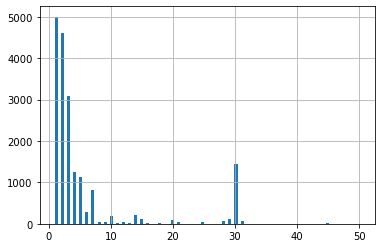

In [27]:
df_edited[df_edited['minimum_nights'].between(0,50)]['minimum_nights'].hist(bins=100)

In [49]:
len(df_edited)

19001

In [50]:
df_edited = df_edited[df_edited['minimum_nights'].between(0,50)]

In [51]:
len(df_edited)

18842

In [52]:
df_edited['minimum_nights'].max()

50

# Check edited data
Now let's make sure that we don't have any major issues remaining. Note that missing values will be taken care of later.

In [54]:
profile = pandas_profiling.ProfileReport(df_edited)
profile.to_widgets()

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# Addional steps for inference pipeline
The steps applied here were specific things to fix for the training data. A number of other steps also need to be performed, but will also need to be applied to the data during inference. These include:

- Impute missing values
- Drop unimportant columns (such as id, name and host_name)

The columns that have many zeros are probably okay (e.g. it is plausible that they have no review or that they have no availability.

# End W&B run
Now we need to end the W&B run so that it will upload the code.

In [55]:
run.finish()